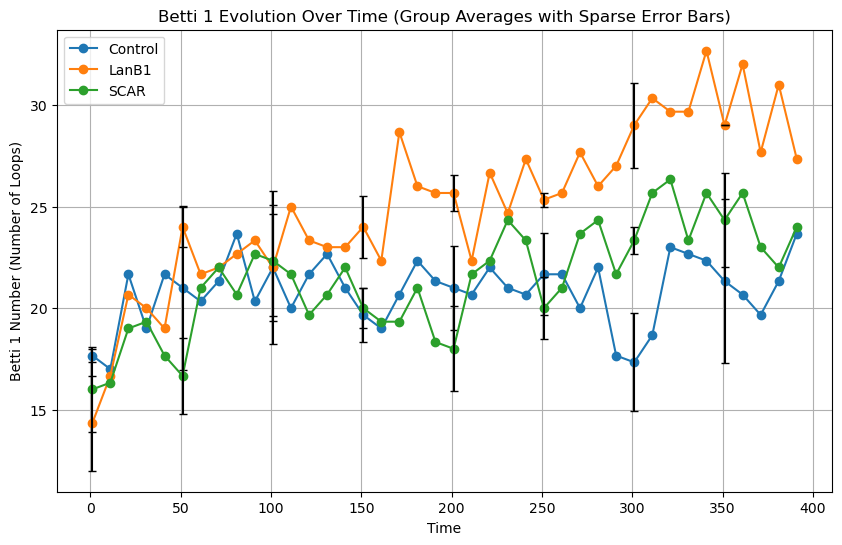

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser

def compute_betti_1(data, times, use_3d=False, persistence_threshold=0):
    """
    Computes the Betti 1 number for each given time using the complete point cloud,
    counting only holes whose persistence (death - birth) is larger than persistence_threshold.
    
    Parameters:
      data                : pandas DataFrame with columns 'Time', 'Position X', 'Position Y', 
                            and optionally 'Position Z'.
      times               : iterable of time values.
      use_3d              : if True, use 3D coordinates; if False, use 2D (X, Y).
      persistence_threshold: Only count holes with (death - birth) greater than this value.
      
    Returns:
      A list of Betti 1 counts (number of 1D holes) for each time.
    """
    betti1_values = []
    for t in times:
        time_data = data[data['Time'] == t]
        if use_3d:
            coords = time_data[['Position X', 'Position Y', 'Position Z']].values
        else:
            coords = time_data[['Position X', 'Position Y']].values

        diagrams = ripser(coords, maxdim=1)['dgms']
        
        
        betti1 = 0
        for birth, death in diagrams[1]:
            if np.isinf(death):
                continue
            if (death - birth) > persistence_threshold:
                betti1 += 1
        
        betti1_values.append(betti1)
    return betti1_values

def compute_group_betti_1(dfs, times, use_3d=False, persistence_threshold=0):
    """
    For a list of replicate DataFrames, compute the Betti 1 evolution over time,
    then average them and calculate the standard error.
    
    Parameters:
      dfs                 : list of pandas DataFrames (each is one replicate).
      times               : iterable of time values.
      use_3d              : if True, use 3D coordinates; else use 2D.
      persistence_threshold: only count holes with persistence above this value.
      
    Returns:
      mean_betti   : array of mean Betti 1 numbers over time.
      stderr_betti : array of standard errors over time.
    """
    replicate_values = []
    for df in dfs:
        betti_vals = compute_betti_1(df, times, use_3d, persistence_threshold)
        replicate_values.append(betti_vals)
    replicate_values = np.array(replicate_values)
    mean_betti = np.mean(replicate_values, axis=0)
    stderr_betti = np.std(replicate_values, axis=0, ddof=1) / np.sqrt(len(dfs))
    return mean_betti, stderr_betti

def plot_group_betti_1(datasets, start_time=1, num_timesteps=40, timestep_interval=10, 
                         use_3d=False, persistence_threshold=0, errorbar_step=5):
    """
    For each mutant group (with replicate datasets), compute the mean Betti 1 evolution 
    over selected timesteps and plot the average with sparse error bars.
    
    Parameters:
      datasets          : dict, keys are mutant labels and values are lists of DataFrames (replicates).
      start_time        : starting time (inclusive).
      num_timesteps     : number of timesteps to analyze.
      timestep_interval : interval between selected time points.
      use_3d            : if True, use 3D coordinates; else use 2D.
      persistence_threshold: only count holes with persistence above this threshold.
      errorbar_step     : plot error bars only on every nth point (to reduce clutter).
    """
    times = [start_time + i * timestep_interval for i in range(num_timesteps)]
    
    plt.figure(figsize=(10, 6))
    for label, dfs in datasets.items():
        mean_betti, stderr_betti = compute_group_betti_1(dfs, times, use_3d, persistence_threshold)
        # Plot the full mean curve
        plt.plot(times, mean_betti, marker='o', linestyle='-', label=label)
        
        # Plot error bars only on a subset of points for clarity
        indices = np.arange(0, len(times), errorbar_step)
        plt.errorbar(np.array(times)[indices], np.array(mean_betti)[indices], 
                     yerr=np.array(stderr_betti)[indices], fmt='none', capsize=3, color='black')
    
    plt.xlabel("Time")
    plt.ylabel("Betti 1 Number (Number of Loops)")
    plt.title("Betti 1 Evolution Over Time (Group Averages with Sparse Error Bars)")
    plt.grid(True)
    plt.legend()
    plt.show()


datasets = {
    "Control": [
        pd.read_csv("Control_130117.csv"),
        pd.read_csv("Control_140117.csv"),
        pd.read_csv("Control_191216.csv")
    ],
    "LanB1": [
        pd.read_csv("LanB1_270317.csv"),
        pd.read_csv("LanB1_280317A.csv"),
        pd.read_csv("LanB1_280317B.csv")
    ],
    "SCAR": [
        pd.read_csv("Scar_140117.csv"),
        pd.read_csv("Scar_151216.csv"),
        pd.read_csv("Scar_201216.csv")
    ]
}


persistence_threshold = 5

plot_group_betti_1(datasets, start_time=1, num_timesteps=40, timestep_interval=10, 
                   use_3d=False, persistence_threshold=persistence_threshold, errorbar_step=5)
